# Assignment #4 - Reinforcement Learning

### <font color="red"> DUE: Nov 26 (Tuesday) 11:00 pm </font>  

<font color="blue"> Sanika Suhas Pol </font>

# I. Overview

The objective of this assignment is to learn and implement reinforcement learning techniques. We do this by applying the paradigm of reinforcement learning to a maze game so that the maze agent can reach its goal. Another game that we will use is the rummy game. The problem statement involves engineering a rummy agent so that we can win the game or reach a minimum score. <br>
The idea behind Reinforcement Learning is that an agent will learn from the environment by interacting with it and receiving rewards for performing actions. In the rummy game we will make a sequence of 3 cards having same rank. After a fix count of rounds, if a player cannot make the required sequence, the player with minimim score wins the game. 

# II. Problems 



## Rummy (Our Way)
![](https://upload.wikimedia.org/wikipedia/commons/9/9a/3_playing_cards.jpg)



### Description:
Rummy is mostly played by 4 players where each player get 10 cards and rest of placed as closed deck.  

But for this assignment to keep it simple, we have changed some rules, reduced the deck of cards and distribution of the cards among each player. Otherwise, the our Q table would be large to handle on our local machines.  

So in this game each player will get 3 cards randomly from 'A' to '5'. With each turn you have to pick a card either from the pile of closed or open cards depending on the cards you have. After that you have to select a card to drop to the pile from your deck. Your goal is to make all of your 3 cards of same number. As soon as one player reaches the goal state, it will meld the cards and game will stop and all other player will get score as the sum of their cards in hand. Player with minimum score will win the game.  

Each player will play for the 10 rounds and if nobody reach to the meld stage then each will player will get score equivalent to the sum of their cards in hand.

Player with the lowest score wins the game.



### <font color="red"> Game Introduction and Rules: </font>

You can only till max turns which is now 20. If you are able to meld your cards, you win otherwise you lose points as per your stash score.

Lets Simulate a Game Round :
The Goal of this game is to collect cards with the same rank.
Naming Conventions to follow H : Hearts, S : Spades, D : Diamonds, C : Clubs. Stash/Hand are the cards which you have. Stash/Hand Score: The sum of the rank of cards. 

- On the first turn you will be given 3 cards from the randomly shuffled deck. Eg: 3H, 2S, AD. Stash Score: 6
- In the next step you will have to either pick a card from pile or the deck. On the first turn, the top card of the deck is on the pile. The card on the pile is visible to you. So Card on the Pile : 2D . You have to decide whether you have to pick this card or you have to pick from pile. Since you alread
- Following the pickup step, you will have to drop one card from the stash/hand. Your Hand : 3H, 2S, AD, 2D
- You can drop any of these cards, but remember if you drop 2S or 2D you might not be able to make a series. So you have to decide whether to drop 3H or AD. Since there are maximum 20 turns, you have to keep your score low as well, Higher the score the higher points you lose. So you decide to drop 3H. Your hand/stash will be: 2S, 2D, AD
- Your opponent will play his hand, he/she shall pick up a card from a pile or deck and the drop a card to the pile.
- Now its your turn. The card on the Pile : 5H. Since picking up this card won't help you much. You decide to pick a card from the Deck. You get lucky, you get a 2C card. Your hand now is 2S, 2D, 2C, AD. Hurray! You can now meld these cards and drop the last card to make your score 0.
- You win this round. Your opponent Stash/Hand score : 15. So you are at 0 points and your opponent is at 15 points. You are ahead of him since you have to keep your score as low as possible.


## Rummy Environment

Importing Libraries

In [1]:
import random 
from functools import reduce
from collections import defaultdict
import numpy as np
from copy import copy
%matplotlib inline

Here, we define the SUITS, RANKS of the cards and their RANK_VALUE.

In [2]:
SUIT = ['H','S','D','C']
RANK = ['A', '2', '3', '4', '5','6','7']
RANK_VALUE = {'A': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'T': 10, 'Q': 10, 'K': 10}

## Card Class Definition
__init__  : Defines the card details such as rank, suit and calculates the rank value


In [3]:
class Card :
    def __init__(self,rank,suit):
        self.rank = rank
        self.suit = suit
        self.rank_to_val = RANK_VALUE[self.rank]
    
    def __str__(self):
        return f'{self.rank}{self.suit}'

    def __repr__(self):
        return f'{self.rank}{self.suit}'

    
    def __eq__(self,other):
        return self.rank == other.rank and self.suit == other.suit
  
# Deck class contains some basic operations performed with the cards:
# 1. Shuffling the cards.
# 2. Drawing card from the deck.

## Deck Class Definition
__shuffle__ : Shuffles the deck in random order

__draw_card__ : Draws a card from the top of the deck

In [4]:
class Deck:
    def __init__(self,packs):
        self.packs = packs
        self.cards = []
        for pack in range(0,packs) :
            for suit in SUIT :
                for rank in RANK :
                    self.cards.append(Card(rank,suit))
    
    def shuffle(self):
        random.shuffle(self.cards)
    
    def draw_card(self):
        card = self.cards[0]
        self.cards.pop(0)
        return card

## Player Class:

### 1.__init__(self,name,stash=list(),isBot=False): 
Initializing stash, name, isBot/dealer points for each player.

### 2. deal_card(self,card):
This method appends the card in the stash and check the condition that length of stash should not be greater than nuber of cards length in game.

### 3. drop_card(self,card):
This method removes the card from stash and add that card into pile.

### 4. meld(self):
This method tries to find the cards with the same rank in the hand. If it finds then it will merge the cards in the hand to the melded cards array in the game. 

### 5. stash_score(self):
This method calculates sum of all the cards in stash according to the rank of each card.

### 6. get_info(self,debug):
This function fetch all the information of the player.

In [5]:
class Player:
  
    """  
        Player class to create a player object.
        eg: player = Player("player1", list(), isBot = False)
        Above declaration will be for your agent.
        All the player names should be unique or else you will get error.
        
    """

    def __init__(self,name,stash=list(),isBot=False,points=0,conn=None):
        self.stash = stash
        self.name = name
        self.game = None
        self.isBot = isBot
        self.points = points
        self.conn = conn
        
    def deal_card(self,card):
        try :
            self.stash.append(card)
            if len(stash) > self.game.cardsLength + 1 :
                raise ValueError('Cannot have cards greater than ')
        except ValueError as err:
            print(err.args)
            
    def drop_card(self,card):
        self.stash.remove(card)
        self.game.add_pile(card)
        return -1

    
    def meld(self):
        card_hash = defaultdict(list)
        for card in self.stash:
            card_hash[card.rank].append(card)
        melded_card_ranks = []
        for (card_rank,meld_cards) in card_hash.items():
            if len(meld_cards) >= 3 :
                self.game.meld.append(meld_cards)
                melded_card_ranks.append(card_rank)
                for card in meld_cards:
                    self.stash.remove(card)
        
        for card_rank in melded_card_ranks :
            card_hash.pop(card_rank)
        return len(melded_card_ranks) > 0

    def stash_score(self) :
        score = 0
        for card in self.stash :
            score += RANK_VALUE[card.rank]
        return score
    
    def get_info(self,debug):
        if debug :
            print(f'Player Name : {self.name} \n Stash Score: {self.stash_score()} \n Stash : {", ".join(str(x) for x in self.stash)}')
        card_ranks = []
        card_suits = []
        pileset = None
        pile = None
        for card in self.stash :
            card_suits.append(RANK_VALUE[card.rank])
            card_ranks.append(card.suit)
        if len(self.game.pile) > 0 : 
            return {"Stash Score" : self.stash_score(), "CardSuit":  card_suits, "CardRanks": card_ranks, "PileRank": self.game.pile[-1].rank, "PileSuit":self.game.pile[-1].suit}
        return {"Stash Score" : self.stash_score(), "CardSuit":  card_suits, "CardRanks": card_ranks}


## Game Enviroment:

### 1. __init():  

### 2. add_pile(self, card):  This method takes a card as argument and first checks number of cards in the deck. If its is ‘0’ then add the cards from file to deck and append the passed card to the pile.

### 3. pick_card(self, player, action):  This methods helps player picking up the card from either Pile or Deck based on action.
			We have defined, If action = 0 then, player will pick a card from Pile
			And if action. = 1 then player will pick card from Deck. 
			Meld condition will be check after player picks the card, if the meld condition satisfied, player won. 
            You can modify the rewards in return, only the values

### 4. pick_from_pile(self, player): This method helps player picking card from the pile and simultaneously a card from pile gets reduced.

### 5. pick_from_deck(self, player): This method is similar to above method but it helps picking up card from the Deck. 

### 6. get_player(self, player_name): This function fetch the details of the player given player_name.

### 7. computer_play(self, player): This method defines the play of the computer/Dealer in following sequence:
			--> Randomly taking actions from picking up card from deck/pile.
			--> Checking the meld condition afterwards.
			--> If the meld condition does not satisfied, remove the card from his stash.

### 8. play(self): This method defines all the function city of play for the player:
		  --> Decrementing the maximum number of turns defined per game.
		  --> For each player, it will check the 'stash', if the 'Stash' for any player = 0 (That player won), it will add the value of each card in stash for all other players.
		  --> Or If maximum number of turns in each round becomes 0, it will add the card values in stash for all the players and return.
      
### 9. drop_card(self,player,card) This method drops a card from the player given player object and card object and returns the reward associated with it.

      --> You can modify the rewards which gets returned in the value.


### 9. reset(self, players): This method will reinitialize all the deck, pile and players.

### 10. _update_turn(self): This method is used to count the number of turns in the game.

In [6]:
class RummyAgent() :
    """
    Simple Rummy Environment
    
    Simple Rummy is a game where you need to make all the cards in your hand same before your opponent does.
    Here you are given 3 cards in your hand/stash to play.
    For the first move you have to pick a card from the deck or from the pile. 
    The card in deck would be random but you can see the card from the pile.
    In the next move you will have to drop a card from your hand.
    Your goal is to collect all the cards of the same rank. 
    Higher the rank of the card, the higher points you lose in the game. 
    You need to keep the stash score low. Eg, if you can AH,7S,5D your strategy would be to either find the first pair of the card or by removing the highest card in the deck.
    You only have 20 turns to either win the same or collect low scoring card.
    You can't see other players cards or their stash scores.
    
    Parameters
    ====
    players: Player objects which will play the game.
    max_card_length : Number of cards each player can have
    max_turns: Number of turns in a rummy game
    """

    def __init__(self,players,max_card_length=5,max_turns=20) :
        self.max_card_length = max_card_length
        self.max_turns = max_turns
        self.reset(players)
        
    def update_player_cards(self,players):
        for player in players :
            player = Player(player.name,list(),isBot=player.isBot,points=player.points,conn=player.conn)
            stash = []
            for i in range(self.max_card_length):
                player.stash.append(self.deck.draw_card())
            player.game = self
            self.players.append(player)
        self.pile = [self.deck.draw_card()]

    def add_pile(self,card):
        if len(self.deck.cards) == 0 :
            self.deck.cards.extend(self.pile)
            self.deck.shuffle()
            self.pile = []
        self.pile.append(card)
        
        
    def pick_card(self,player,action):
        if action == 0:
            self.pick_from_pile(player)
        else :
            self.pick_from_deck(player)
        if player.meld() :
            return {"reward" : 10}
        else :
            return {"reward" : -1}
#             return -player.stash_score()
       
    def pick_from_pile(self,player):
        card = self.pile[-1]
        self.pile.pop()
        return player.stash.append(card)
     
    def pick_from_deck(self,player):
        return player.stash.append(self.deck.draw_card())
    
    def get_player(self,player_name):
        return_player = [player for player in self.players if player.name == player_name]
        if len(return_player) != 1:
            print("Invalid Player")
            return None
        else:
            return return_player[0]
    
    def drop_card(self,player,card):
        player.drop_card(card)
        return {"reward" : -1}
    
  
    def computer_play(self,player):
        #Gets a card from deck or pile
        if random.randint(0,1) == 1 :
            self.pick_from_pile(player)
        else :
            self.pick_from_deck(player)
            
        #tries to meld if it can
#         if random.randint(0,10) > 5 :
        player.meld()
        
        #removes a card from the stash
        if len(player.stash) != 0:
            card = player.stash[(random.randint(0,len(player.stash) - 1))]
            player.drop_card(card)
        
    def play(self):
        for player in self.players :
            if len(player.stash) == 0 :
                return True
        if self.max_turns <= 0 :
            return True
        return False

    def _update_turn(self):
        self.max_turns -= 1  
    
    def reset(self,players,max_turns=20):
        self.players = []
        self.deck = Deck(1)
        self.deck.shuffle()
        self.meld = []
        self.pile = []
        self.max_turns = max_turns
        self.update_player_cards(players)




### Example Run with Random Players

This following code shows how to create an environment and players to play 10 games with 20 maximum rounds. This only includes random picking up of card and dropping.  

In [7]:
p1 = Player('tabish',list())
p2 = Player('comp1',list(),isBot=True)
rummy = RummyAgent([p1,p2],max_card_length=3,max_turns=20)

In [8]:
maxiter = 3
debug = True
for j in range(maxiter):
        for player in rummy.players :
            player.points = player.stash_score()
        
        rummy.reset(rummy.players)
        random.shuffle(rummy.players)
        # int i = 0 
        if debug :
            print(f'**********************************\n\t\tGame Starts : {j}\n***********************************')
        while not rummy.play() :    
            rummy._update_turn()
            print(rummy.max_turns)       
            for player in rummy.players:
                if player.isBot :
                    if rummy.play():
                        continue
                    if debug :
                        print(f'{player.name} Plays')
                    rummy.computer_play(player)
                    if debug :
                        player.get_info(debug)
                        if player.stash == 0 :
                            print(f'{player.name} wins the round')

                else :
                    if rummy.play() :
                        continue
                    if debug :
                        print(f'{player.name} Plays')
                    player_info = player.get_info(debug)
                    action_taken = np.random.choice(1)
                    if debug :
                        print(f'Card in pile {player_info["PileSuit"]}{player_info["PileRank"]}')
                    result_1 = rummy.pick_card(player,action_taken)
                    result_1 = result_1["reward"]

                    if debug : 
                        print(f'{player.name} takes action {action_taken}')
                    #player stash will have no cards if the player has melded them 
                    #When you have picked up a card and you have drop it since the remaining cards have been melded. 
                    if len(player.stash) == 1:
                        rummy.drop_card(player,player.stash[0])
                        if debug :
                            print(f'{player.name} Wins the round')

                    elif len(player.stash) != 0 :

                        player_info = player.get_info(debug)
                        s = player_info['CardRanks']
                        action_taken = np.random.choice(4)
                        card = player.stash[action_taken]
                        if debug :
                            print(f'{player.name} drops card {card}')

                        result_1 = rummy.drop_card(player,card)
                        result_1 = result_1["reward"]
#                             pdb.set_trace()
                    else :
                        if debug :
                            print(f'{player.name} Wins the round')
                    if debug :
                        player.get_info(debug)
        


**********************************
		Game Starts : 0
***********************************
19
comp1 Plays
Player Name : comp1 
 Stash Score: 15 
 Stash : 4C, 4H, 7C
tabish Plays
Player Name : tabish 
 Stash Score: 9 
 Stash : 4D, 3S, 2S
Card in pile HA
tabish takes action 0
Player Name : tabish 
 Stash Score: 10 
 Stash : 4D, 3S, 2S, AH
tabish drops card 3S
Player Name : tabish 
 Stash Score: 7 
 Stash : 4D, 2S, AH
18
comp1 Plays
Player Name : comp1 
 Stash Score: 17 
 Stash : 4H, 7C, 6C
tabish Plays
Player Name : tabish 
 Stash Score: 7 
 Stash : 4D, 2S, AH
Card in pile C4
tabish takes action 0
Player Name : tabish 
 Stash Score: 11 
 Stash : 4D, 2S, AH, 4C
tabish drops card 4C
Player Name : tabish 
 Stash Score: 7 
 Stash : 4D, 2S, AH
17
comp1 Plays
Player Name : comp1 
 Stash Score: 15 
 Stash : 4H, 6C, 5S
tabish Plays
Player Name : tabish 
 Stash Score: 7 
 Stash : 4D, 2S, AH
Card in pile C7
tabish takes action 0
Player Name : tabish 
 Stash Score: 14 
 Stash : 4D, 2S, AH, 7C
tabish 

# III. Methods

- Decide your TD learning approach: SARSA or Q-learning? 
- Decide your function approximator.
- Describe your approach and the reason why you select it.
- Finish epsilon_greedy function and other TODOs. Explain it.
- Explain your codes.

## Review of the SARSA and Q-Learning
Temporal Difference is a model-free reinforcement learning algorithm. This means that the agent learns through actual experience rather than through a readily available all-knowing-hack-book (transition table). Temporal Difference algorithms enable the agent to learn through every single action it takes.
When there are large number of states, the memory requirement grows exponentially. 
*Temporal difference (TD) learning* considers that the agent knows only the partial information of the MDP. 
With only current and next state transition and without any model transition probability, TD lets the agent explore the environment to examine the random policy. 
With an estiate of the value function $V(s)$, $\hat{V}(s)$, 

   $$ 
        \begin{align}
        V(s_t) &= R_{t+1} + \gamma V(s_{t+1}) \\
        V(s_t) &\sim R_{t+1} + \gamma \hat{V}(s_{t+1}) \\
        \Rightarrow \quad \delta_t &= R_{t+1} + \gamma \hat{V}(s_{t+1}) - V(s_t).
        \end{align}
    $$
    
Here, $\delta$ represents the *temporal diffrence error*. 
We can use this error as a gradient to update the value estimation.

$$
    \begin{align}
        V(s_t) &\leftarrow R_{t+1} + \alpha \delta_t \\
        V(s_t) &\leftarrow R_{t+1} + \alpha (R_{t+1} + \gamma \hat{V}(s_{t+1}) - V(s_t))
    \end{align}
$$


### Example Model

<img src="http://webpages.uncc.edu/mlee173/teach/itcs6156/images/class/rl_simple_model.png" width=700 />

**Q-learning and SARSA are both policy control methods which work on evaluating the optimal Q-value for all action-state pairs**
### Sarsa: 
State–action–reward–state–action (SARSA) is an on-policy TD control method. We update the Q with assumption that we follow a certain behavior policy. Thus, we call this as *on-policy control*, or **SARSA**. 

$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)) 
$$

The psedocode for the SARSA Algorithm is as follows

**[Algorithm: SARSA]**
![](http://incompleteideas.net/book/ebook/pseudotmp8.png)


### Q-Learning
Q-Learning is an off-policy TD control policy. It’s exactly like SARSA with the only difference being — it doesn’t follow a policy to find the next action A’ but rather chooses the action in a greedy fashion. In Q-learning, without making assumption of behavior policy, we can explore other possible policies to update the Q. Hence, we call this as *off-policy control*, or **Q-learning**. 

$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)) 
$$

**[Algorithm: Q-learning]**
![](http://incompleteideas.net/book/ebook/pseudotmp9.png)

### Choice of TD learning and Reason
- The difference between SARSA and Qlearning is that SARSA takes the next action based on the current policy while qlearning takes the action with maximum utility of next state. Q-learning directly learns the optimal policy, whilst SARSA learns a near-optimal policy whilst exploring. Q- learning is exactly like SARSA with the only difference being it doesn’t follow a policy to find the next action A’ but rather chooses the action in a greedy fashion.
- Q-learning directly learns the optimal policy, whilst SARSA learns a near-optimal policy whilst exploring. If you want to learn an optimal policy using SARSA, then you will need to decide on a strategy to decay 𝜖 in 𝜖-greedy action choice, which may become a fiddly hyperparameter to tune.
- Q-learning (and off-policy learning in general) has higher per-sample variance than SARSA, and may suffer from problems converging as a result. This turns up as a problem when training neural networks via Q-learning.
- SARSA will approach convergence allowing for possible penalties from exploratory moves, whilst Q-learning will ignore them. That makes SARSA more conservative if there is risk of a large negative reward close to the optimal path, Q-learning will tend to trigger that reward whilst exploring, whilst SARSA will tend to avoid a dangerous optimal path and only slowly learn to use it when the exploration parameters are reduced. 
- An algorithm like Q-learning would be preferable in situations where we do not care about the agent's performance during the training process, but we just want it to learn an optimal greedy policy that we'll switch to eventually. For example, that we play a few practice games (where we don't mind losing due to randomness sometimes), and afterwards play an important tournament where we'll stop learning and switch over from epsilon-greedy to the greedy policy. This is where Q-learning would be better.

Hence I select Q-learning approach.


### Choice of Function Approximation and Reason

In the Q learning, Q table will give us a better approximation by iteratively updating the states using the bellman equation. We can explore possible policies to update the Q table. We then select the maximum value fromt the Q table. <br>
Q leanring uses the off policy technique which means it updates the value without making behavioral assumption.
To use Q-values with function approximation, we need to find features that are functions of states and actions. The linear function is Q(s,a)=θ0⋅1+θ1ϕ1(s,a)+⋯+θnϕn(s,a)=θTϕ(s,a)

## RLAgent for Rummy

Referencing the RLAgent in the lecture note, make your own agent class for the game. 

### Implementation of the selected approach (RLAgent)

In [9]:
class RLRummyAgent: 
    """
        Reinforcement Learning Agent Model for training/testing
        with Tabular function approximation
        
    """
    
    def __init__(self, env_rummy):
        self.env_rummy = env_rummy
        self.Q = np.zeros((7, 7, 7, 7, 2, 4))
        
    def epsilon_greed_pick(self, s):
        if np.random.uniform() < self.epsilon:
            idx = np.random.randint(2)
        else:
            idx = np.where(self.Q[s[0], s[1], s[2], s[3], :, 0] == np.max(self.Q[s[0], s[1], s[2], s[3], :, 0]))[0][0]
        return idx

    def epsilon_greed_drop(self, s):
        if np.random.uniform() < self.epsilon:
            idx = np.random.randint(4)
        else:
            idx = np.where(self.Q[s[0], s[1], s[2], s[3], 0, :] == np.max(self.Q[s[0], s[1], s[2], s[3], 0, :]))[0][0]
        return idx
    
    def train(self, maxiter, **params):
        debug = True
        for j in range(maxiter):
            for player in self.env_rummy.players :
                player.points = player.stash_score()
        
            self.env_rummy.reset(self.env_rummy.players)
            random.shuffle(self.env_rummy.players)
            # int i = 0 
            if debug :
                print(f'********************************\n\t\tGame Starts : {j}\n*********************************')
            while not self.env_rummy.play() :    
                self.env_rummy._update_turn()
                print(self.env_rummy.max_turns)       
                for player in self.env_rummy.players:
                    if player.isBot :
                        if self.env_rummy.play():
                            continue
                        if debug :
                            print(f'{player.name} Plays')
                        self.env_rummy.computer_play(player)
                        if debug :
                            player.get_info(debug)
                            if player.stash == 0 :
                                print(f'{player.name} wins the round')

                    else :
                        if self.env_rummy.play() :
                            continue
                        if debug :
                            print(f'{player.name} Plays')
                        player_info = player.get_info(debug)
                        action_taken = np.random.choice(1)
                        if debug :
                            print(f'Card in pile {player_info["PileSuit"]}{player_info["PileRank"]}')
                        result_1 = self.env_rummy.pick_card(player,action_taken)
                        result_1 = result_1["reward"]

                        if debug : 
                            print(f'{player.name} takes action {action_taken}')
                        if len(player.stash) == 1:
                            self.env_rummy.drop_card(player,player.stash[0])
                            if debug :
                                print(f'{player.name} Wins the round')

                        elif len(player.stash) != 0 :

                            player_info = player.get_info(debug)
                            s = player_info['CardRanks']
                            action_taken = np.random.choice(4)
                            card = player.stash[action_taken]
                            if debug :
                                print(f'{player.name} drops card {card}')

                            result_1 = self.env_rummy.drop_card(player,card)
                            result_1 = result_1["reward"]
                        else :
                            if debug :
                                print(f'{player.name} Wins the round')
                        if debug :
                            player.get_info(debug)
                    
    def test(self, start, maxstep=1000):
        epsilon = 0
        env.init(start)
        s = env.get_cur_state()
        # selection an action
        a = self.epsilon_greed(epsilon, s)

        trace = np.array(coord_convert(s, self.size))
        # run simulation for max number of steps 
        for step in range(maxstep):
            # move
            r = env.next(a)
            s1 = env.get_cur_state()
            a1 = self.epsilon_greed(epsilon, s1)

            trace = np.vstack((trace, coord_convert(s1, self.size)))

            if env.is_goal(): # reached the goal
                break

            s = s1
            a = a1 

        return trace                

In [10]:
player1 = Player('Sanika',list())
player2 = Player('Comp1',list(),isBot=True)
myrummy = RummyAgent([player1,player2],max_card_length=3,max_turns=20)

In [11]:
play_rummy = RLRummyAgent(myrummy)
play_rummy.train(3)

********************************
		Game Starts : 0
*********************************
19
Comp1 Plays
Player Name : Comp1 
 Stash Score: 12 
 Stash : AC, 7D, 4S
Sanika Plays
Player Name : Sanika 
 Stash Score: 14 
 Stash : 5C, 3H, 6C
Card in pile HA
Sanika takes action 0
Player Name : Sanika 
 Stash Score: 15 
 Stash : 5C, 3H, 6C, AH
Sanika drops card AH
Player Name : Sanika 
 Stash Score: 14 
 Stash : 5C, 3H, 6C
18
Comp1 Plays
Player Name : Comp1 
 Stash Score: 11 
 Stash : AC, 7D, 3D
Sanika Plays
Player Name : Sanika 
 Stash Score: 14 
 Stash : 5C, 3H, 6C
Card in pile S4
Sanika takes action 0
Player Name : Sanika 
 Stash Score: 18 
 Stash : 5C, 3H, 6C, 4S
Sanika drops card 3H
Player Name : Sanika 
 Stash Score: 15 
 Stash : 5C, 6C, 4S
17
Comp1 Plays
Player Name : Comp1 
 Stash Score: 7 
 Stash : AC, 3D, 3H
Sanika Plays
Player Name : Sanika 
 Stash Score: 15 
 Stash : 5C, 6C, 4S
Card in pile D7
Sanika takes action 0
Player Name : Sanika 
 Stash Score: 22 
 Stash : 5C, 6C, 4S, 7D
Sanika 

### Explanation of the codes

- The RLRummyAgent is a the class for rummy agent. 
- The init function initialized the environment.
- The train function trains the RL agent.

# IV - Results

- Describe the choice of your parameters for $\gamma$, $\alpha$, and $\epsilon$. 
  - Run experiments to find good parameters
  - Show the experimental outputs to show the process of your selection
- Visualize the results and explain outputs (even from mine.)
  - Run the codes and tell me what you observe
  - Add more visualizations to enrich your explanation.

## Implementation of Maze environment and agent for selection of parameters

In [12]:
# maze example
import collections
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class GridWorld:
    """ Grid World environment
            there are four actions (left, right, up, and down) to move an agent
            In a grid, if it reaches a goal, it get 30 points of reward.
            If it falls in a hole or moves out of the grid world, it gets -5.
            Each step costs -1 point. 

        to test GridWorld, run the following sample codes:

            env = GridWorld('grid.txt')

            env.print_map()
            print [2,3], env.check_state([2,3])
            print [0,0], env.check_state([0,0])
            print [3,4], env.check_state([3,4])
            print [10,3], env.check_state([10,3])

            env.init([0,0])
            print env.next(1)  # right
            print env.next(3)  # down
            print env.next(0)  # left
            print env.next(2)  # up
            print env.next(2)  # up

        Parameters
        ==========
        _map        ndarray
                    string array read from a file input
        _size       1d array
                    the size of _map in ndarray
        goal_pos    tuple
                    the index for the goal location
        _actions    list
                    list of actions for 4 actions
        _s          1d array
                    current state
    """
    def __init__(self, fn):
        # read a map from a file
        self._map = self.read_map(fn)
        self._size = np.asarray(self._map.shape)
        self.goal_pos = np.where(self._map == 'G')

        # definition of actions (left, right, up, and down repectively)
        self._actions = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self._s = None

    def get_cur_state(self):
        return self._s

    def get_size(self):
        return self._size

    def read_map(self, fn):
        grid = []
        with open(fn) as f:
            for line in f:
               grid.append(list(line.strip()))
        return np.asarray(grid)

    def print_map(self):
        print( self._map )

    def check_state(self, s):
        if isinstance(s, collections.Iterable) and len(s) == 2:
            if s[0] < 0 or s[1] < 0 or\
               s[0] >= self._size[0] or s[1] >= self._size[1]:
               return 'N'
            return self._map[tuple(s)].upper()
        else:
            return 'F'  # wrong input

    def init(self, state=None):
        if state is None:
            s = [0, 0]
        else:
            s = state

        if self.check_state(s) == 'O':
            self._s = np.asarray(state)
        else:
            raise ValueError("Invalid state for init")

    def next(self, a):
        s1 = self._s + self._actions[a]
        # state transition
        curr = self.check_state(s1)
        
        if curr == 'H' or curr == 'N':
            return -5
        elif curr == 'F':
            warnings.warn("invalid state " + str(s1))
            return -5
        elif curr == 'G':
            self._s = s1
            return 30
        else:
            self._s = s1
            return -1
        
    def is_goal(self):
        return self.check_state(self._s) == 'G'
            
    def get_actions(self):
        return self._actions

In [13]:
env = GridWorld("grid.txt")
env.print_map()

[['O' 'O' 'O' 'H' 'O' 'O' 'O' 'O' 'O']
 ['O' 'O' 'O' 'H' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'H' 'O' 'O']
 ['O' 'O' 'O' 'O' 'H' 'H' 'H' 'O' 'O']
 ['O' 'O' 'H' 'O' 'O' 'O' 'O' 'O' 'H']
 ['O' 'O' 'H' 'O' 'O' 'O' 'G' 'O' 'O']
 ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']]


In [14]:
def coord_convert(s, sz):
    return [s[1], sz[0]-s[0]-1]

In [15]:
class RLAgent: 
    """
        Reinforcement Learning Agent Model for training/testing
        with Tabular function approximation
        
    """
    
    def __init__(self, evn):
        self.env = env
        self.size = env.get_size()
        self.n_a = len(env.get_actions())
        # self.Q table including the surrounding border
        self.Q = np.zeros((self.size[0], self.size[1], self.n_a))
    
    def epsilon_greed(self, epsilon, s):
        if np.random.uniform() < epsilon:
            a = np.random.randint(self.n_a)
        else:
            i_max = np.where(self.Q[s[0], s[1], :] == np.max(self.Q[s[0], s[1], :]))[0]
            a = int(np.random.choice(i_max))
        return a
    
    def train(self, start, **params):
        
        # parameters
        gamma = params.pop('gamma', 0.99)
        alpha = params.pop('alpha', 0.1)
        epsilon= params.pop('epsilon', 0.1)
        maxiter= params.pop('maxiter', 1000) 
        maxstep= params.pop('maxstep', 1000)
        
        # init self.Q matrix
        self.Q[...] = 0
        self.Q[self.env._map == 'H'] = -np.inf
        
        # online train
        # rewards and step trace
        rtrace = []
        steps = []
        for j in range(maxiter):

            env.init(start)
            s = env.get_cur_state()
            # selection an action
            a = self.epsilon_greed(epsilon, s)

            rewards = []
            trace = np.array(coord_convert(s, self.size))
            # run simulation for max number of steps 
            for step in range(maxstep):
                # move
                r = env.next(a)
                s1 = env.get_cur_state()
                a1 = self.epsilon_greed(epsilon, s1)

                rewards.append(r)
                trace = np.vstack((trace, coord_convert(s1, self.size)))

                # update self.Q table (SARSA)
                self.Q[s[0], s[1], a] += alpha * (r + gamma * self.Q[s1[0], s1[1], a1] - self.Q[s[0], s[1], a])

                if env.is_goal(): # reached the goal
                    self.Q[s1[0], s1[1], a1] = 0
                    break

                s = s1
                a = a1

            rtrace.append(np.sum(rewards))
            steps.append(step+1)
        return rtrace, steps, trace # last trace of trajectory

    def test(self, start, maxstep=1000):
        epsilon = 0
        env.init(start)
        s = env.get_cur_state()
        # selection an action
        a = self.epsilon_greed(epsilon, s)

        trace = np.array(coord_convert(s, self.size))
        # run simulation for max number of steps 
        for step in range(maxstep):
            # move
            r = env.next(a)
            s1 = env.get_cur_state()
            a1 = self.epsilon_greed(epsilon, s1)

            trace = np.vstack((trace, coord_convert(s1, self.size)))

            if env.is_goal(): # reached the goal
                break

            s = s1
            a = a1 

        return trace            

In [16]:
### Plotting tools 

def plot_trace(agent, start, trace, title="test trajectory"):
    plt.plot(trace[:, 0], trace[:, 1], "ko-")
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.xlim([0, agent.size[1]])
    plt.ylim([0, agent.size[0]])
    

def plot_train(agent, rtrace, steps, trace, start):

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(221)
    plt.plot(rtrace, "b-")
    plt.ylabel("sum of rewards")

    ax1 = fig.add_subplot(222)
    plt.plot(steps)
    plt.ylabel("# steps")

    # contour plot for agent.Q
    ax2 = fig.add_subplot(223)
    xs = range(agent.size[1])
    ys = range(agent.size[0])
    maxQ = np.max(agent.Q, axis=2)
    h_b = (maxQ==-np.inf)
    maxQ[h_b] = 0
    maxQ[h_b] = np.min(maxQ) - 100
    cs = plt.contourf(xs, ys[::-1], maxQ)
    plt.colorbar(cs)
    plt.text(env.goal_pos[1], agent.size[0]-env.goal_pos[0]-1, 'G')
    plt.text(start[1], agent.size[0]-start[0]-1, 'S')
    plt.ylabel("max agent.Q")

    # plot traces
    ax3 = fig.add_subplot(224)
    plot_trace(agent, start, trace, "trace of the last episode")

    plt.plot()

In [17]:
agent = RLAgent(env)
start = [0,0]
rtrace, steps, trace = agent.train(start, 
                                   amma=0.99, 
                                   alpha=0.1, 
                                   epsilon=0.1, 
                                   maxiter=100, 
                                   maxstep=1000)

/Users/sanikapol/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working


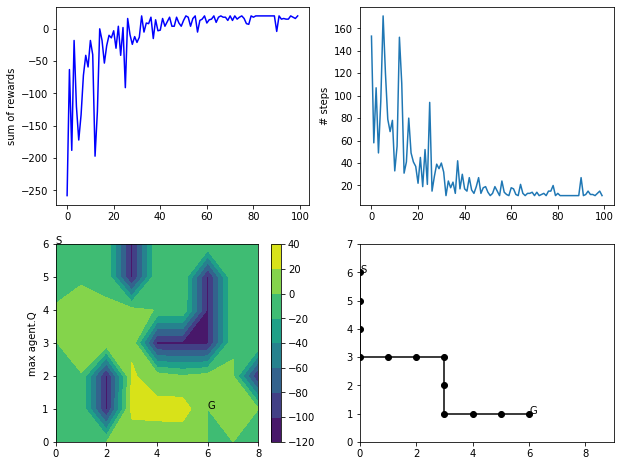

In [18]:
plot_train(agent, rtrace, steps, trace, start)

## Experimental outputs that show the choice of parameters. How do you choose them?

### Calculating optimal parameters. 

I have selcted few values for gamma, alpha and epsilon. I am iterating over those vales and ploting them. The plots show trace of the rewards gained with values of alpha, gamma and epsilon. The values returning maximum reward are returned as optimal values.

Optimal gamma = 0.2


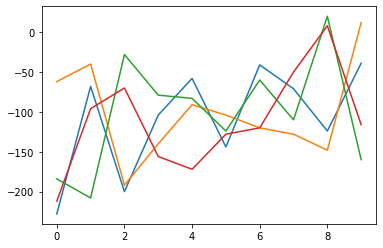

Optimal alpha = 0.2


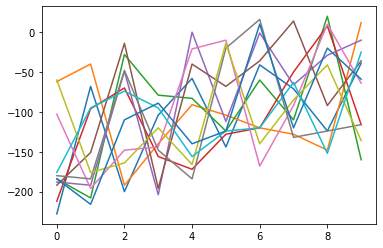

Optimal epsilon = 0.5


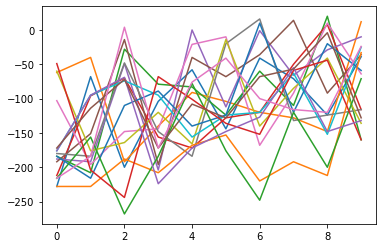

In [21]:
optimal_Agent = RLAgent(env)
each_gammas = [0.9,0.5,0.2,0.1]
each_alphas = [0.9,0.5,0.2,0.1,0.05,0.02,0.01]
each_epsilons = [0.9,0.8,0.5,0.4,0.2,0.1]

each_rewards = []
for gamma in each_gammas:
    rtrace, steps, trace = optimal_Agent.train(start, 
                                   gma=gamma, 
                                   alpha=0.1, 
                                   epsilon=0.1, 
                                   maxiter=10, 
                                   maxstep=100)
    each_rewards.append(rtrace)
max_rewards = []
for i in each_rewards:
    plt.plot(i)
    max_rewards.append(i[np.argmax(i)])
optimal_gamma = each_gammas[np.argmax(max_rewards)]
print("Optimal gamma = " + str(optimal_gamma))
plt.show()
for alphas in each_alphas:
    rtrace, steps, trace = optimal_Agent.train(start, 
                                   gma=0.99, 
                                   alpha=alphas, 
                                   epsilon=0.1, 
                                   maxiter=10, 
                                   maxstep=100)
    each_rewards.append(rtrace)
max_rewards = []
plt.show()
for i in each_rewards:
    plt.plot(i)
    max_rewards.append(i[np.argmax(i)])
optimal_alpha = each_alphas[np.argmax(max_rewards)]
print("Optimal alpha = " + str(optimal_alpha))
for epsilons in each_epsilons:
    rtrace, steps, trace = optimal_Agent.train(start, 
                                   gma=0.99, 
                                   alpha=0.1, 
                                   epsilon=epsilons, 
                                   maxiter=10, 
                                   maxstep=100)
    each_rewards.append(rtrace)
max_rewards = []
plt.show()
for i in each_rewards:
    plt.plot(i)
    max_rewards.append(i[np.argmax(i)])
optimal_epsilon = each_epsilons[np.argmax(max_rewards)]
print("Optimal epsilon = " + str(optimal_epsilon))
    
    

## Reports the selected parameters

In [22]:
print('Optimal gamma = ',optimal_gamma)
print('Optimal alpha = ',optimal_alpha)
print('Optimal epsilon = ',optimal_epsilon)

Optimal gamma =  0.2
Optimal alpha =  0.2
Optimal epsilon =  0.5


## Output plots with various values of parameters

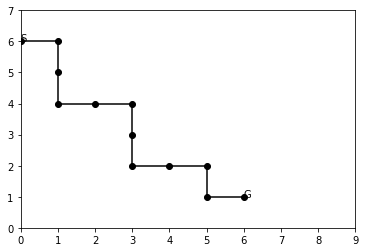

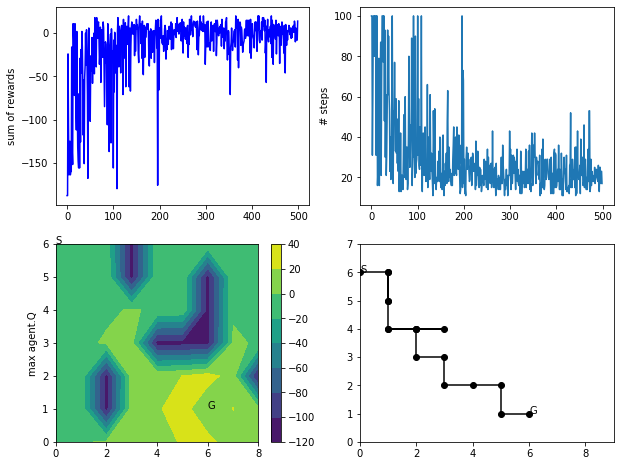

In [36]:
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.9, 
                                   alpha=0.1, 
                                   epsilon=0.5, 
                                   maxiter=500, 
                                   maxstep=100)
test_start = [0,0]
test_trace = agent.test(test_start)
plot_trace(agent,test_start,test_trace)
plot_train(agent, rtrace, steps, trace, start)

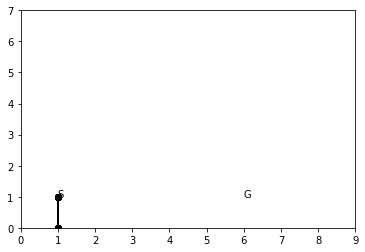

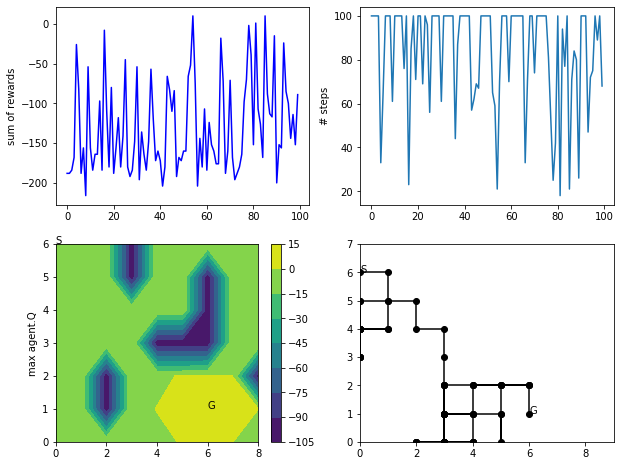

In [35]:
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.7, 
                                   alpha=0.01, 
                                   epsilon=0.7, 
                                   maxiter=100, 
                                   maxstep=100)
test_start = [5,1]
test_trace = agent.test(test_start)
plot_trace(agent,test_start,test_trace)
plot_train(agent, rtrace, steps, trace, start)

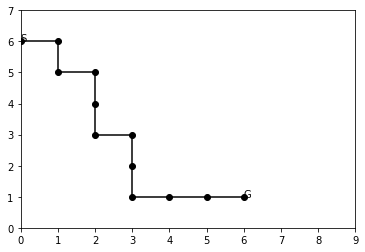

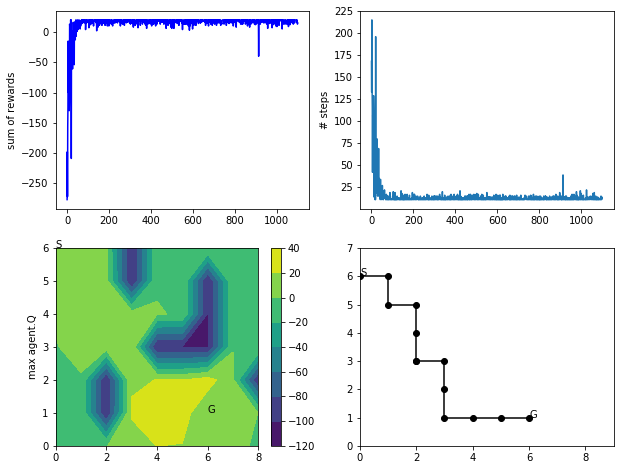

In [26]:
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.9, 
                                   alpha=0.1, 
                                   epsilon=0.1, 
                                   maxiter=1100, 
                                   maxstep=500)

test_start = [0,0]
test_trace = agent.test(test_start)
plot_trace(agent,test_start,test_trace)
plot_train(agent, rtrace, steps, trace, start)

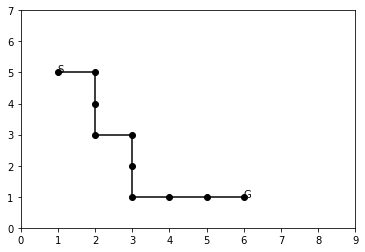

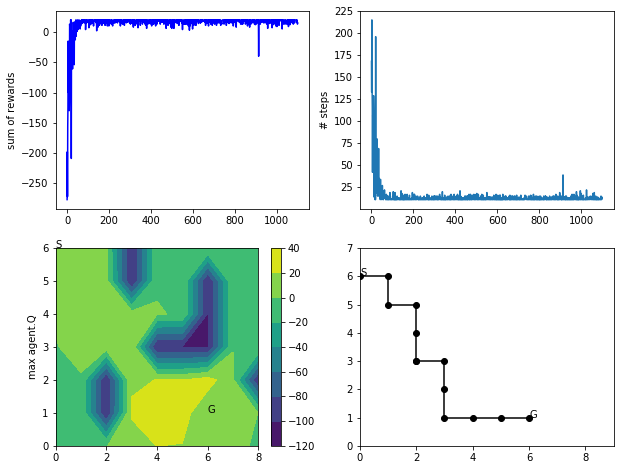

In [27]:
test_start = [1,1]
test_trace = agent.test(test_start)
plot_trace(agent,test_start,test_trace)
plot_train(agent, rtrace, steps, trace, start)

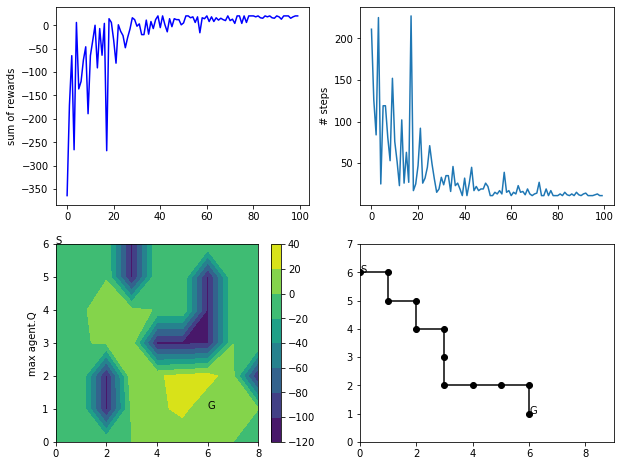

In [29]:
rtrace, steps, trace = agent.train(start, 
                                   gamma=0.90, 
                                   alpha=0.1, 
                                   epsilon=0.1, 
                                   maxiter=100, 
                                   maxstep=500)
plot_train(agent, rtrace, steps, trace, start)

## Reading and analysis of learning results and plots
- For few vaues the agent does not reach the goal. 
- The agent starts from different positions for differnt tests.

# V. Conclusions

- In this assignement learned about reinforcement learning in detail. 
- I understood working of RL algorithms such as Q-Learning and SARSA.
- I had to read the assignment several times to understand what is to be done on the asignment.
- I could not figure out the states for Q table clearly and could only partially visualize them.
- It was difficult for me to implement the rummy agent and hence could implement it only partially. 

# References

1. Ælex, et al. “What Is the Difference between Q-Learning and SARSA?” Stack Overflow, 1 Sept. 1961, https://stackoverflow.com/questions/6848828/what-is-the-difference-between-q-learning-and-sarsa.
2. “Notebook on Nbviewer.” Jupyter Notebook Viewer, https://nbviewer.jupyter.org/url/webpages.uncc.edu/mlee173/teach/itcs6156/notebooks/notes/Note-ReinforcementLearning.Sol.ipynb.


# Extra Credit for Tournament Top16!

- In two classes, we will have qualification and tournament.
- To participate the tournament, you need to use this [client](http://nbviewer.jupyter.org/url/webpages.uncc.edu/mlee173/teach/itcs6156/notebooks/assign/StudentClient.ipynb) codes.
- Locally you can run the [server](http://nbviewer.jupyter.org/url/webpages.uncc.edu/mlee173/teach/itcs6156/notebooks/assign/SERVER.ipynb) to verify your run. 

### Qualification Round 

- In qualification game, individual will play against a fixed policy agent on the server
  - You can access the server: TBA
  
  - Highly ranked (by the profit) will proceed to the tournament.
  - max. 32 players will be cut for main tournament (by 11 pm on Dec 1st).
  
### Tournament

- In tournament, 4 players will be play in each round.
  - In a table game, two best scoring players will proceed to next round
  - In final, the game will ends in 50 rounds and winner will be the one with lowest balance. 

## Grading

We will test your notebook with an additional grid.txt file. Please make sure to test in different maze input files. 

points | | description
--|--|:--
5 | Overview| states the objective and the appraoch 
35 | Methods | 
 |10| Review of the SARSA and Q-Learning
 | 5| Choice of TD learning and Reason
 | 5| Choice of Function Approximation and Reason
 |10| Implementation of the selected approach (RLAgent)
 | 5| explanation of the codes
45 | Results 
 |10| Reports the selected parameters 
 |15| Experimental outputs that show the choice of parameters. How do you choose them?
 |10| Output plots (5 for each)
 |10| reading and analysis of learning results and plots
10 | Participation to the tournament.
5 | Conclusions 
